In [1]:
import numpy as np
import matplotlib.pyplot as plt
cmap = plt.get_cmap('tab10')
import time

from popodds import log_odds, ModelComparison, KDE

In [2]:
np.random.seed(42)

## Mock simulation and posterior

In [3]:
# Power law log PDF
def log_powerlaw(x, index, minimum, maximum):
    
    log_shape = index * np.log(x)
    # WLOG we can take absolute value inside the log to prevent negative arguments
    # because we can factor out -1 in numerator and denominator
    log_norm = np.log(np.abs(index+1)) - np.log(np.abs(maximum**(index+1) - minimum**(index+1)))
    cut = (minimum <= x) * (x <= maximum)
    
    return np.where(cut, log_shape + log_norm, -np.inf)
    
# Sample from a power law PDF
def sample_powerlaw(n_samples, index, minimum, maximum):
    
    return (
        np.random.rand(n_samples) * (maximum**(index+1) - minimum**(index+1))
        + minimum**(index+1)
        )**(1 / (index+1))

# Uniform log PDF
def log_flat(x, minimum, maximum):
    
    log_shape = 0.0
    log_norm = -np.log(maximum - minimum)
    cut = (minimum <= x) * (x <= maximum)
    
    return np.where(cut, log_shape + log_norm, -np.inf)

In [4]:
# Make a fiducial population
index = -1.2
model_min = 1
model_max = 100

# Model samples
n_model = 10_000
model_samples = sample_powerlaw(n_model, index, model_min, model_max)

# Model evaluation
model_log_pdf = lambda x: log_powerlaw(x, index, model_min, model_max)

In [5]:
# Mock parameter estimation with flat prior and Gaussian posterior

prior_min = 0
prior_max = 100
prior_log_pdf = lambda x: log_flat(x, prior_min, prior_max)
prior_samples = np.random.uniform(prior_min, prior_max, 5_000)

posterior_mean = 50
posterior_std = 5
posterior_samples = np.random.normal(posterior_mean, posterior_std, 5_000)

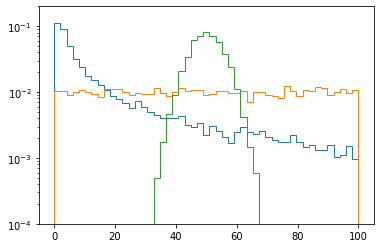

In [6]:
bins = np.linspace(0, 100, 50)

for samples in (model_samples, prior_samples, posterior_samples):
    plt.hist(samples, bins=bins, density=True, histtype='step')

plt.semilogy()
plt.ylim(1e-4, .2);

## Bayes factor between new and original prior

In [7]:
# The ModelComparison class constructs density estimates on the model samples
# The model and/or prior can also be predefined callables for the log PDFs

mc = ModelComparison(model_samples, prior_log_pdf, posterior_samples)

In [8]:
# Evaluate the Bayes factor

t0 = time.time()
print(mc.bayes_factor())
print(time.time() - t0)

0.28792951757455326
1.9632742404937744


In [9]:
# Value is cached after first computation
# This is useful if the model and/or prior is given as samples for KDEs,
# which are slow

t0 = time.time()
print(mc.bayes_factor())
print(time.time() - t0)

0.28792951757455326
0.0001964569091796875


In [10]:
# We can also return the log Bayes factor (also cached)
print(mc.log_bayes_factor())

# Equivalently:
print(mc())

-1.2450395594415342
-1.2450395594415342


In [11]:
# The Bayes factor can be compute from samples or log PDFs
# There will be differences due to finite sampling and KDEs
# Use explicit forms for the model and prior where possible

print(ModelComparison(model_samples, prior_log_pdf, posterior_samples)())
print(ModelComparison(model_log_pdf, prior_samples, posterior_samples)())
print(ModelComparison(model_samples, prior_samples, posterior_samples)())
print(ModelComparison(model_log_pdf, prior_log_pdf, posterior_samples)())

-1.2450395594415342
-1.1794796103791771
-1.2452467604033375
-1.1795412337989593


In [12]:
# As a sanity check:

ModelComparison(prior_log_pdf, prior_log_pdf, posterior_samples)()

0.0

## Posterior odds

In [13]:
# log_odds is a functional wrapper of ModelComparison to compute posterior odds
# It additionally takes the priors_odds argument
# If prior_odds = 1 (default), this is the same as the Bayes factor

log_odds(model_log_pdf, prior_log_pdf, posterior_samples)

-1.1795412337989593

In [14]:
# If we believe the model is ten times more likely than the original prior:

log_odds(model_log_pdf, prior_log_pdf, posterior_samples, prior_odds=10)

1.1230438591950866

## Prior bounds

In [15]:
# When using model and/or prior samples, we can enforce bounds on the KDE
# It is slow due to the boundary reflective method employed

model_bounds = (model_min, model_max)
mc = ModelComparison(
    model_samples, prior_log_pdf, posterior_samples, model_bounds=model_bounds,
    )
print(mc())

prior_bounds = (prior_min, prior_max)
log_bf = log_odds(
    model_samples, prior_samples, posterior_samples, prior_bounds=prior_bounds,
    )
print(log_bf)

-1.1238732355304393
-1.2353467656253967


In [16]:
# When the model or prior is given as a callable, bounds has no effect

bf = ModelComparison(
    model_log_pdf, prior_log_pdf, posterior_samples,
    model_bounds=None, prior_bounds=None,
    ).bayes_factor()
print(bf)

bf = ModelComparison(
    model_log_pdf, prior_log_pdf, posterior_samples,
    model_bounds=model_bounds, prior_bounds=prior_bounds,
    ).bayes_factor()
print(bf)

0.30741974004157446
0.30741974004157446


## Comparison between two different models

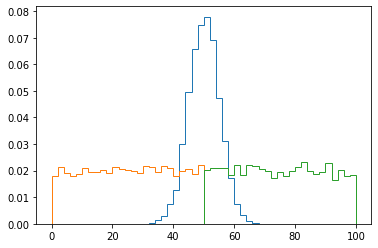

In [17]:
# Make two fiducial populations

modelA_log_pdf = lambda x: log_flat(x, 0, 50)
modelB_log_pdf = lambda x: log_flat(x, 50, 100)

samplesA = np.random.uniform(0, 50, 5_000)
samplesB = np.random.uniform(50, 100, 5_000)

for samples in (posterior_samples, samplesA, samplesB):
    plt.hist(samples, bins=np.linspace(0, 100, 51), density=True, histtype='step')

In [18]:
# The Bayes factor between A and B is just given by the ratio of the two
# Bayes factors over the original prior

mcA = ModelComparison(modelA_log_pdf, prior_log_pdf, posterior_samples)
bfA = mcA.bayes_factor()

mcB = ModelComparison(modelB_log_pdf, prior_log_pdf, posterior_samples)
bfB = mcB.bayes_factor()

bfAB = bfA / bfB
print(bfAB)

0.9623233908948208


In [19]:
# Equivalently:

log_bfA = log_odds(modelA_log_pdf, prior_log_pdf, posterior_samples)
log_bfB = log_odds(modelB_log_pdf, prior_log_pdf, posterior_samples)

log_bfAB = log_bfA - log_bfB
print(log_bfAB)
print(np.exp(log_bfAB))

-0.03840471963595071
0.9623233908948207


In [20]:
# If we believe model B is ten times more likely than model A:
prior_oddsBA = 10

log_oddsA = log_odds(
    modelA_log_pdf, prior_log_pdf, posterior_samples, prior_odds=1,
    )
log_oddsB = log_odds(
    modelB_log_pdf, prior_log_pdf, posterior_samples, prior_odds=prior_oddsBA,
    )

log_oddsAB = log_oddsA - log_oddsB
print(log_oddsAB)

-2.3409898126299966


In [21]:
# Equivalently:
prior_oddsAB = 1 / 10

log_oddsA = log_odds(
    modelA_log_pdf, prior_log_pdf, posterior_samples, prior_odds=prior_oddsAB,
    )
log_oddsB = log_odds(
    modelB_log_pdf, prior_log_pdf, posterior_samples, prior_odds=1,
    )

log_oddsAB = log_oddsA - log_oddsB
print(log_oddsAB)

-2.340989812629996


In [22]:
# For convenience, log_odds can do this calculation for you

log_odds(
    modelA_log_pdf, prior_log_pdf, posterior_samples, prior_odds=prior_oddsAB,
    second_model=modelB_log_pdf,
    )

-2.340989812629996

## Kernel density estimation

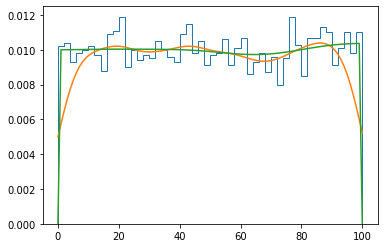

In [23]:
# The underlying class computing PDFs on samples is popodds.KDE
# It's a wrapper of scipy.stats.gaussian_kde to handle bounded domains
# It sets zero PDF gradients at boundaries by reflecting the data

x = np.linspace(0, 100, 100)

kde = KDE(prior_samples)
pdf = kde.pdf(x)

bounded_kde = KDE(prior_samples, bounds=prior_bounds)
bounded_pdf = bounded_kde.pdf(x)

plt.hist(prior_samples, bins=50, density=True, histtype='step')
plt.plot(x, pdf)
plt.plot(x, bounded_pdf);